In [2]:
using WebIO
WebIO.install_jupyter_nbextension()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-15830137566797497295\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13773361883780601470\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-15830137566797497295\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Installing Jupyter WebIO extension...
│   cmd = `/Users/MrTrololord/.julia/conda/3/bin/jupyter nbextension install --user /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/bundles/webio-jupyter-notebook.js`
└ @ WebIO /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/jupyter.jl:237
Up to date: /Users/MrTrololord/Library/Jupyter/nbextensions/webio-jupyter-notebook.js

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable <the entry point> --user
    
┌ Info: Enabling Jupyter WebIO extension...
│   cmd = `/Users/MrTrololord/.julia/conda/3/bin/jupyter nbextension enable --user webio-jupyter-notebook`
└ @ WebIO /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/jupyter.jl:241
Enabling notebook extension webio-jupyter-notebook...
      - Validating: OK


In [13]:
using Dierckx, ScatteredInterpolation, PyPlot, Random, BenchmarkTools, DataFrames, TableView;
import LAP_julia: helpers.mse, helpers.vec_len, helpers.angle_rmse, helpers.angle_mae, gen_tiled_flow, showflow
import PyCall: PyObject
using JLD2, FileIO

## Functions to be tested

In [4]:
# methods that work well and will be tested: Thin splate spline (Polyharmonic(2)), Multiquadratic
"""
    test_scatter(points, samples, smoothness; method)

`points` should be an n×k matrix, where n is dimension of the sampled space and k is the number of points. This means that each column in the matrix defines one point.
`samples` is an k×m array, where k is the number of sampled points (same as for points) and m is the dimension of the sampled data.

"""
function test_scatter(flow_size, points, samples; method)
    gridPoints = meshgrid(flow_size...)'
    itp = interpolate(method, points, samples);
    interpolated = ScatteredInterpolation.evaluate(itp, gridPoints)
    gridded = reshape(interpolated, flow_size)
    return gridded
end



function test_dier(flow_size, x, y, z1, z2)
    storage = 1000
    spl1 = Spline2D(x, y, z1; w=ones(length(x)), kx=1, ky=1, s=storage)
    real1 = evalgrid(spl1, 1:flow_size[1], 1:flow_size[2])

    spl2 = Spline2D(x, y, z2; w=ones(length(x)), kx=1, ky=1, s=storage)
    imag1 = evalgrid(spl2, 1:flow_size[1], 1:flow_size[2])

    gridded = real1 .+ imag1 .* im
    return gridded
end


meshgrid(x, y) = [repeat(x, outer=length(y)) repeat(y, inner=length(x))];
meshgrid(x::Real, y::Real) = [repeat(1:x, outer=y) repeat(1:y, inner=x)];


## Prepare new DataFrame

In [26]:
scatter_interp_bench = DataFrame(
                                Index = Int[],
                                Method = String[],
                                Mode = String[],
                                Point_count = Int[],
                                Median_speed = Float64[],
                                Magnitude_of_MSE = Float64[],
                                Angle_RMS = Float64[],
                                Angle_mean = Float64[],
                                Benchmark = BenchmarkTools.Trial[],
                                Truth_flow = Matrix[],
                                Method_flow = Matrix[])

df = scatter_interp_bench

# test output
# showtable(df)

# store run errors of methods
# each entry has: (method name, flow, inds, error output)
errors = [];

## Load Dataframe

In [25]:
@load "dataframe_df.jld2" df

KeyError: KeyError: key "df" not found

# Test

In [28]:


# parameters:
test_count = 30
flow_size = (200, 200)


Methods = ["Dier",
           "Scatter-Thin_plate_spline",
           "Scatter-Multiquadratic"]

Modes = ["Random_points",
         "Semigridded",
         "Gridded"]

Point_counts = [9,
                16,
                25,
                49,
                81,
                100,
                144]

let
    index = 0

    for test in 1:test_count
        flow = gen_tiled_flow(flow_size, 30, 40)
        for point_count in Point_counts
            for point_mode in Modes
                inds = gen_rand_points(flow, point_count, point_mode)
                for method in Methods
                        x = [ind[1] for ind in inds]
                        y = [ind[2] for ind in inds]
                    if method == "Dier"
                        # set inputs
                        z1 = [real(flow[ind]) for ind in inds]
                        z2 = [imag(flow[ind]) for ind in inds]
                        # check if method errors, if yes then log and skip
                        try
                            method_flow = test_dier(flow_size, x, y, z1, z2)
                        catch e
                            push!(errors, (method, flow, inds, e))
                            continue
                        end
                        # eval with current input
                        method_flow = test_dier(flow_size, x, y, z1, z2)
                        # do a benchmark
                        bench = @benchmark test_dier($flow_size, $x, $y, $z1, $z2)
                    elseif method == "Scatter-Thin_plate_spline"
                        # set inputs
                        points = reshape([ind[i] for i=1:length(inds[1]) for ind=inds], length(inds), length(inds[1]))'
                        samples = [flow[I] for I in inds]
                        # check if method errors, if yes then log and skip
                        try
                            method_flow = test_scatter(flow_size, points, samples; method = Polyharmonic(2))
                        catch e
                            push!(errors, (method, flow, inds, e))
                            continue
                        end
                        # eval with current input
                        method_flow = test_scatter(flow_size, points, samples; method = Polyharmonic(2))
                        # do a benchmark
                        bench = @benchmark test_scatter($flow_size, $points, $samples; method = $Polyharmonic(2))
                    elseif method == "Scatter-Multiquadratic"
                        # set inputs
                        points = reshape([ind[i] for i=1:length(inds[1]) for ind=inds], length(inds), length(inds[1]))'
                        samples = [flow[I] for I in inds]
                        # check if method errors, if yes then log and skip
                        try
                            method_flow = test_scatter(flow_size, points, samples; method = Multiquadratic(2))
                        catch e
                            push!(errors, (method, flow, inds, e))
                            continue
                        end
                        # eval with current input
                        method_flow = test_scatter(flow_size, points, samples; method = Multiquadratic(2))
                        # do a benchmark
                        bench = @benchmark test_scatter($flow_size, $points, $samples; method = $Multiquadratic(2))
                    end
                    # ADD TO DATA FRAME
                    index = index + 1
                    println("at index ", index)
                    push!(df, Dict(:Index => index,
                                   :Method => method,
                                   :Mode => point_mode,
                                   :Point_count => point_count,
                                   :Median_speed => median(bench).time / (10^6),
                                   :Magnitude_of_MSE => vec_len(mse(method_flow, flow)),
                                   :Angle_RMS => angle_rmse(method_flow, flow),
                                   :Angle_mean => angle_mae(method_flow, flow),
                                   :Benchmark => bench,
                                   :Truth_flow => flow,
                                   :Method_flow => method_flow))
                end
            end
        end
    end
end # let

# save df to file
@save "dataframe_df.jld2" df


at index 1
at index 2
at index 3
at index 4
at index 5
at index 6
at index 7
at index 8
at index 9
at index 10
at index 11
at index 12
at index 13
at index 14
at index 15
at index 16
at index 17
at index 18
at index 19
at index 20
at index 21
at index 22
at index 23
at index 24
at index 25
at index 26
at index 27
at index 28
at index 29
at index 30
at index 31
at index 32
at index 33
at index 34
at index 35
at index 36
at index 37
at index 38
at index 39
at index 40
at index 41
at index 42
at index 43
at index 44
at index 45
at index 46
at index 47
at index 48
at index 49
at index 50
at index 51
at index 52
at index 53
at index 54
at index 55
at index 56
at index 57
at index 58
at index 59
at index 60
at index 61
at index 62
at index 63
at index 64
at index 65
at index 66
at index 67
at index 68
at index 69
at index 70
at index 71
at index 72
at index 73
at index 74
at index 75
at index 76
at index 77
at index 78
at index 79
at index 80
at index 81
at index 82
at index 83
at index 84
a

at index 640
at index 641
at index 642
at index 643
at index 644
at index 645
at index 646
at index 647
at index 648
at index 649
at index 650
at index 651
at index 652
at index 653
at index 654
at index 655
at index 656
at index 657
at index 658
at index 659
at index 660
at index 661
at index 662
at index 663
at index 664
at index 665
at index 666
at index 667
at index 668
at index 669
at index 670
at index 671
at index 672
at index 673
at index 674
at index 675
at index 676
at index 677
at index 678
at index 679
at index 680
at index 681
at index 682
at index 683
at index 684
at index 685
at index 686
at index 687
at index 688
at index 689
at index 690
at index 691
at index 692
at index 693
at index 694
at index 695
at index 696
at index 697
at index 698
at index 699
at index 700
at index 701
at index 702
at index 703
at index 704
at index 705
at index 706
at index 707
at index 708
at index 709
at index 710
at index 711
at index 712
at index 713
at index 714
at index 715
at index 716

at index 1251
at index 1252
at index 1253
at index 1254
at index 1255
at index 1256
at index 1257
at index 1258
at index 1259
at index 1260
at index 1261
at index 1262
at index 1263
at index 1264
at index 1265
at index 1266
at index 1267
at index 1268
at index 1269
at index 1270
at index 1271
at index 1272
at index 1273
at index 1274
at index 1275
at index 1276
at index 1277
at index 1278
at index 1279
at index 1280
at index 1281
at index 1282
at index 1283
at index 1284
at index 1285
at index 1286
at index 1287
at index 1288
at index 1289
at index 1290
at index 1291
at index 1292
at index 1293
at index 1294
at index 1295
at index 1296
at index 1297
at index 1298
at index 1299
at index 1300
at index 1301
at index 1302
at index 1303
at index 1304
at index 1305
at index 1306
at index 1307
at index 1308
at index 1309
at index 1310
at index 1311
at index 1312
at index 1313
at index 1314
at index 1315
at index 1316
at index 1317
at index 1318
at index 1319
at index 1320
at index 1321
at ind

In [24]:
# each entry has: (method name, flow, inds, error output)
#                 (1          , 2   , 3   , 4           )  
errors[1][3];

save = deepcopy(df)
# Wierd results in thin plate spline:
method_flows = save[(save.Magnitude_of_MSE .> 1000), :][:, :Method_flow]
figure()
method_flows[1]
plt.show()

In [21]:
showtable(df)

Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol,Any}(:style => Dict("height" => "0","padding" => "0","background-color" => "#F5F7F7","color" => "#1c1f20","font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}(:id => "grid-4f235a12",:className => "ag-theme-balham",:style => Dict("height" => "500px","width" => "100%")))], Dict{Symbol,Any}()), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing)), Set(String[]), nothing, Asset[Asset("js", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/src/rowNumberRenderer.js"), Asset("js", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid.js"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid.css"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid-light.css"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid-dark.css")], Dict{Any,Any}(), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000011ca65b10, Task (runnable) @0x000000011ca65b10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"1391778968755809779\",\"id\":\"ob_14\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"onCellDoubleClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellDoubleClicked\",\"scope\":\"1391778968755809779\",\"id\":\"ob_12\",\"type\":\"observable\"},x)}),\"multiSortKey\":\"ctrl\",\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":true,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Int64\",\"field\":\"Index\",\"headerName\":\"Index\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":true,\"editable\":false,\"headerTooltip\":\"String\",\"field\":\"Method\",\"headerName\":\"Method\",\"sortable\":true,\"type\":null,\"resizable\":true},{\"filter\":true,\"editable\":false,\"headerTooltip\":\"String\",\"field\":\"Mode\",\"headerName\":\"Mode\",\"sortable\":true,\"type\":null,\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Int64\",\"field\":\"Point_count\",\"headerName\":\"Point_count\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"Median_speed\",\"headerName\":\"Median_speed\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"Magnitude_o

## Print some results

This is a summary describtion of the method results based on the number of points:

In [22]:
point_count_df = DataFrame(Point_c = Int[],
                           Method = String[],
                           Median_speed_mean = Float64[],
                           Magnitude_of_MSE_mean = Float64[],
                           Angle_RMS_mean = Float64[],
                           Angle_Mean_mean = Float64[])

for points in Point_counts
    for method in Methods
        tmp_df = df[(df.Point_count .== points) .& (df.Method .== method), :]
        tmp_df = select(tmp_df, :Median_speed, :Magnitude_of_MSE, :Angle_RMS, :Angle_mean)
        test_count = length(tmp_df.Median_speed)
        tmp_df = describe(tmp_df)
        retrieved_data = round.(tmp_df[:, :mean], digits=2)
        push!(point_count_df, vcat([points, method], retrieved_data))
    end
end

showtable(point_count_df)

Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol,Any}(:style => Dict("height" => "0","padding" => "0","background-color" => "#F5F7F7","color" => "#1c1f20","font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}(:id => "grid-636e47f2",:className => "ag-theme-balham",:style => Dict("height" => "500px","width" => "100%")))], Dict{Symbol,Any}()), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing)), Set(String[]), nothing, Asset[Asset("js", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/src/rowNumberRenderer.js"), Asset("js", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid.js"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid.css"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid-light.css"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/TableView/CxWLO/deps/ag-grid-22.1.0/ag-grid-dark.css")], Dict{Any,Any}(), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000014d452ad0, Task (runnable) @0x000000014d452ad0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"12153189244729481676\",\"id\":\"ob_19\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"onCellDoubleClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellDoubleClicked\",\"scope\":\"12153189244729481676\",\"id\":\"ob_17\",\"type\":\"observable\"},x)}),\"multiSortKey\":\"ctrl\",\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":true,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Int64\",\"field\":\"Point_c\",\"headerName\":\"Point_c\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":true,\"editable\":false,\"headerTooltip\":\"String\",\"field\":\"Method\",\"headerName\":\"Method\",\"sortable\":true,\"type\":null,\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"Median_speed_mean\",\"headerName\":\"Median_speed_mean\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"Magnitude_of_MSE_mean\",\"headerName\":\"Magnitude_of_MSE_mean\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"Angle_RMS_mean\",\"headerName\":\"Angle_RMS_mean\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agN

In [82]:

small_point_count = 50
describtion = 0

for method in Methods
    println("***** ",method, " *****")
    describtion = describe(df[(df.Point_count .< small_point_count) .& (df.Method .== method), :])
    display(describtion)
end

#showtable(describtion)
#df[(df.Index .== 1) .& (df.Point_count .== 9), :].Median_speed

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Index,220.167,1,175.0,600,,,Int64
2,Method,,Dier,,Dier,1,,String
3,Mode,,Gridded,,Semigridded,3,,String
4,Point_count,24.75,9,20.5,49,,,Int64
5,Median_speed,1.84213,1.58699,1.74149,3.86872,,,Float64
6,Magnitude_of_MSE,30.6886,0.508992,21.0834,224.097,,,Float64
7,Angle_RMS,85.4658,46.9068,80.9761,164.12,,,Float64
8,Angle_mean,54.1782,23.1612,50.6807,124.452,,,Float64
9,Benchmark,,,,,216,,Trial


,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,Index,221.167,2,176.0,601
2,Method,,Scatter-Thin_plate_spline,,Scatter-Thin_plate_spline
3,Mode,,Gridded,,Semigridded
4,Point_count,24.75,9,20.5,49
5,Median_speed,67.2906,22.9751,59.1704,198.843
6,Magnitude_of_MSE,17.7207,0.0901523,5.79276,210.232
7,Angle_RMS,54.6622,11.6065,52.1221,139.181
8,Angle_mean,23.9116,2.53875,20.8745,84.8586
9,Benchmark,,,,


***** Dier *****
***** Scatter-Thin_plate_spline *****


,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,Index,222.167,3,177.0,602
2,Method,,Scatter-Multiquadratic,,Scatter-Multiquadratic
3,Mode,,Gridded,,Semigridded
4,Point_count,24.75,9,20.5,49
5,Median_speed,23.63,9.38008,21.5229,82.637
6,Magnitude_of_MSE,14.0923,0.201809,7.40831,147.468
7,Angle_RMS,58.8762,15.7193,56.0063,136.228
8,Angle_mean,26.9873,4.23305,24.3457,85.9709
9,Benchmark,,,,


***** Scatter-Multiquadratic *****


In [14]:
"""
    gen_rand_points(flow, point_count, mode; max_skew_const=4)

Generate `point_count` random indices over `flow` depending on selection `mode`.
"""
function gen_rand_points(flow, point_count, mode; max_skew_const=4)
    if mode == "Random_points"
        ret_inds = rand(CartesianIndices(flow), point_count)
    elseif mode == "Gridded"
        points_in_dim = round(Int64, sqrt(point_count))
        point_spacing = floor.(size(flow) ./ points_in_dim)

        ret_inds = Array{CartesianIndex{2}, 1}(undef, 0)
        for ind in CartesianIndices(flow)
            if all((Tuple(ind)) .% point_spacing .== 0)
                add_ind = CartesianIndex(Tuple(ind) .- floor.(Int64, point_spacing ./ 2))
                push!(ret_inds, add_ind)
            end
        end
    elseif mode == "Semigridded"
        points_in_dim = round(Int64, sqrt(point_count))
        point_spacing = floor.(size(flow) ./ points_in_dim)

        ret_inds = Array{CartesianIndex{2}, 1}(undef, 0)
        for ind in CartesianIndices(flow)
            if all((Tuple(ind)) .% point_spacing .== 0)
                skew = (rand((-floor(Int64, point_spacing[1]/max_skew_const):floor(Int64, point_spacing[1]/max_skew_const))),
                        rand((-floor(Int64, point_spacing[1]/max_skew_const):floor(Int64, point_spacing[2]/max_skew_const))))
                add_ind = CartesianIndex(Tuple(ind) .- floor.(Int64, point_spacing ./ 2) .+ skew)
                @assert add_ind in CartesianIndices(flow)

                push!(ret_inds, add_ind)
            end
        end
    end
    return ret_inds
end

gen_rand_points

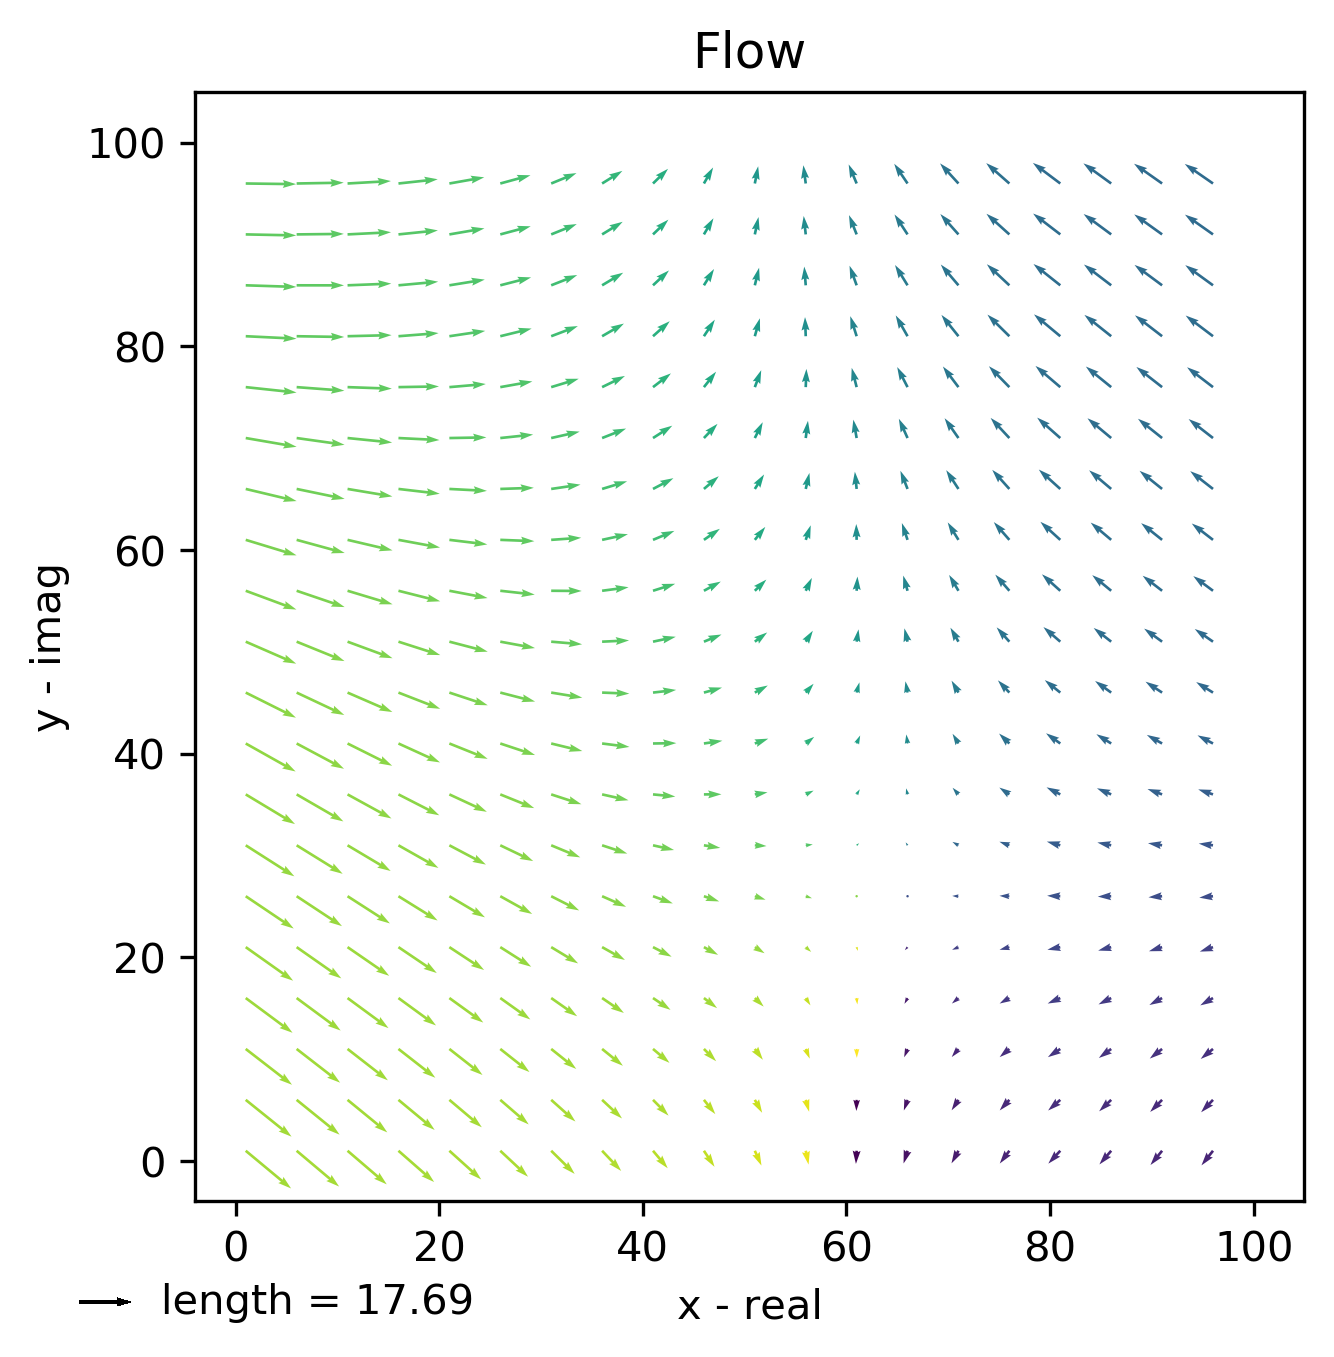

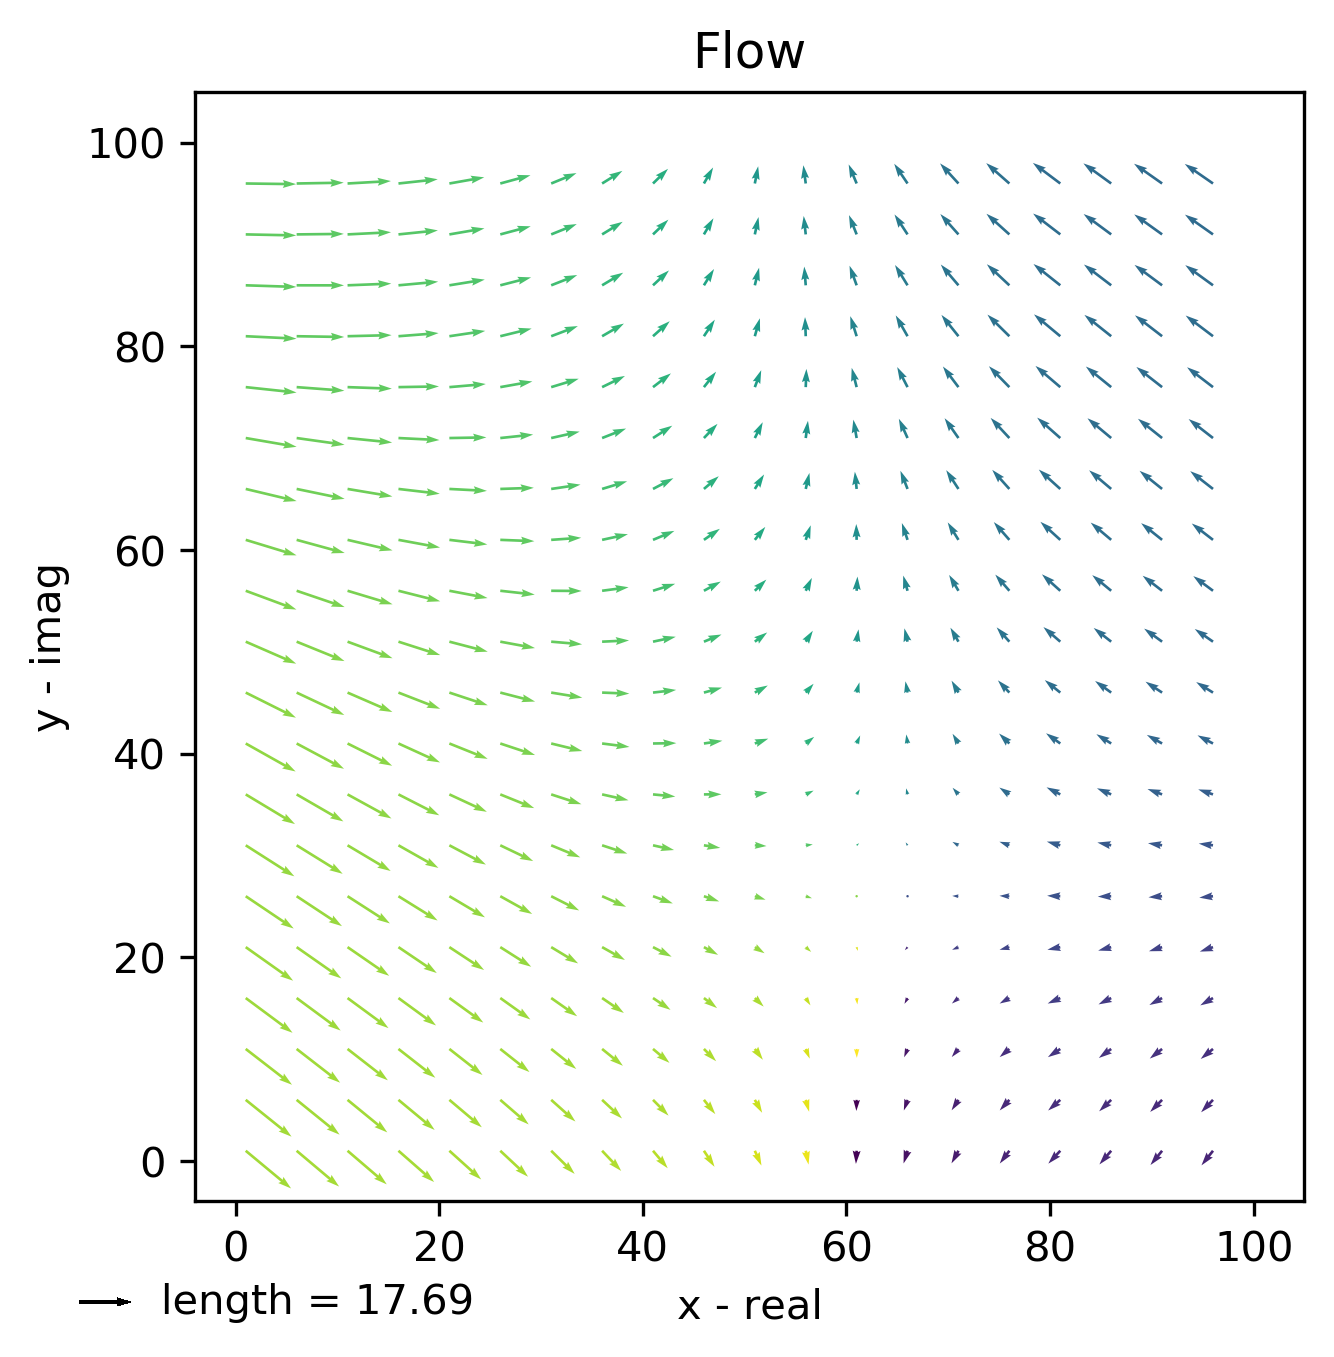

In [20]:
flow = gen_tiled_flow((100, 100), 20, 40)
obj = showflow(flow, ret="PyObject");
gcf()

In [126]:
using PyPlot
pygui(true)
obj
gcf()

Figure(PyObject <Figure size 1280x960 with 0 Axes>)